# RT2 assignment
## Makoto Mezawa
This notebook is to replace the user interface from the terminal itself (the action client node «A»)

Import the libraries we need

In [1]:
import rospy
import jupyros as jr
import ipywidgets as widgets
import actionlib
from actionlib_msgs.msg import GoalStatus, GoalStatusArray
from assignment_2_2023.msg import PlanningAction,PlanningActionResult, PlanningGoal, Custom, Goal
from nav_msgs.msg import Odometry
from assignment_2_2023.srv import GetTargetPosition
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Some definition about setting the goals and cancel them.
is_goal_reached_callback is the definition where acts when the robot reaches the target and is rekated to plotting the number of the reached or non-reached target.

In [2]:
robot_info_pub = None

switch_reach = 0
flag = True

def send_button(b):
    with output: 
        target_x = float(x_decided.value)
        target_y = float(y_decided.value)
        # set goal position and publish the msg
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = target_x
        goal.target_pose.pose.position.y = target_y
        
        target_msg = Goal()
        target_msg.target_x = target_x
        target_msg.target_y = target_y

        robot_target_pub.publish(target_msg)
        action_client.send_goal(goal)
        
        # update target plot
        vis.add_target_update_plot(target_x, target_y)
        
        print("Goal sended")
        
        print("Goal Status:", action_client.get_state())
        print("Goal Result:", action_client.get_result())
        
def cancel_button(b):
    with output: 
        print("Target cancelled.")
        action_client.cancel_goal()
        
# def is_goal_reached_callback(msg):
#     global switch_reach
#     for status in msg.status_list:
#         if status.status == GoalStatus.SUCCEEDED and switch_reach == 1:
#             vis.mark_target_reached_and_update_plot()
#             switch_reach = 0
#         else:
#             switch_reach = 1
            
def is_goal_reached_callback(msg):
    global switch_reach
    if msg.status == 3 and switch_reach == 1:
        vis.mark_target_reached_and_update_plot()
        switch_reach = 0
    elif msg.status != 3:
        switch_reach = 1
        
#initialize ROS node
rospy.init_node('action_client_node')

#Create action client node
action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
action_client.wait_for_server()

# Publish Custom msg
robot_info_pub = rospy.Publisher('/robot_info', Custom, queue_size=10)
robot_target_pub = rospy.Publisher('/target_info', Goal, queue_size=10)

# Subscribe information
#rospy.Subscriber('/odom', Odometry, odom_callback)

setting widget about sending the goal

In [3]:
x_decided = widgets.IntText(value=0, description='x_decided')
target_xb = widgets.IntSlider(value=0, min=-10, max=10, description='target_xb') 
display(x_decided, target_xb)

y_decided = widgets.IntText(value=0, description='y_decided')
target_yb = widgets.IntSlider(value=0, min=-10, max=10, description='target_yb') 
display(y_decided, target_yb)

mylinkx = widgets.jslink((x_decided, 'value'), (target_xb, 'value'))
mylinky = widgets.jslink((y_decided, 'value'), (target_yb, 'value'))

but_send = widgets.Button(description="Send goal") 
output = widgets.Output()

display(but_send, output)
        
but_send.on_click(send_button)

IntText(value=0, description='x_decided')

IntSlider(value=0, description='target_xb', max=10, min=-10)

IntText(value=0, description='y_decided')

IntSlider(value=0, description='target_yb', max=10, min=-10)

Button(description='Send goal', style=ButtonStyle())

Output()

button about canceling the goal

In [4]:
button = widgets.Button(description="Cancel") 
output = widgets.Output()

display(button, output)
#handle changes, the observe method of the widget can be used to register a callback.

button.on_click(cancel_button)

Button(description='Cancel', style=ButtonStyle())

Output()

Visualizing part

<IPython.core.display.Javascript object>


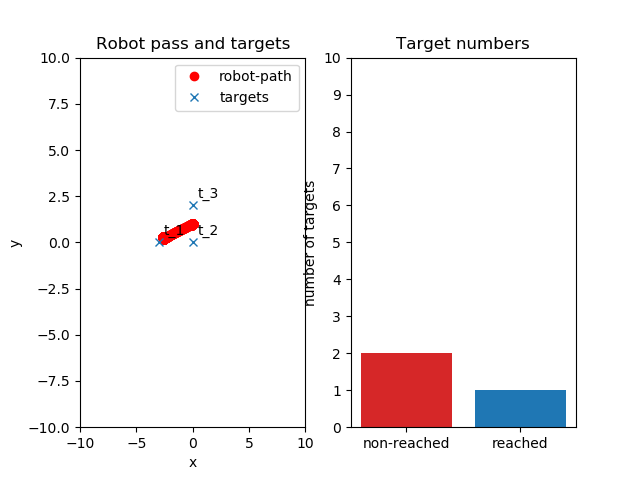

In [5]:
%matplotlib notebook
class Visualiser:
    def __init__(self):
        # tracking plot
        self.fig, (self.ax, self.ax2) = plt.subplots(1,2)
        self.ln, = self.ax.plot([], [], 'ro', label = 'robot-path')
        self.x_ptar, = self.ax.plot([], [], 'x', label = 'targets')
        self.x_data, self.y_data = [], []
        self.x_tar, self.y_tar = [], []
        
        # plot about the number of the targets
        self.bar_labels = ['non-reached', 'reached']
        self.bar_colors = ['tab:red', 'tab:blue']
        self.targets_reached, self.targets = [] , []

        self.bar = self.ax2.bar(self.bar_labels, [0,0], label=self.bar_labels, color=self.bar_colors)


    def plot_init(self):
        self.ax.set_title('Robot pass and targets')
        self.ax.set_ylabel('y')
        self.ax.set_xlabel('x')
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.legend()
        
        self.ax2.set_title('Target numbers')
        self.ax2.set_ylim(0, 10)
        self.ax2.set_yticks(range(11))
        self.ax2.set_ylabel('number of targets')
        return self.ln,
        
    def add_target_update_plot(self, x, y):
        self.x_tar.append(x)
        self.y_tar.append(y)
        self.targets.append((x,y))
        self.x_ptar.set_data(self.x_tar, self.y_tar)
        self.ax.text(self.x_tar[-1] + 0.4, self.y_tar[-1] + 0.4, f't_{len(self.x_tar)}')
        self.update_second_plot()
        
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln,
    
    def mark_target_reached_and_update_plot(self):
        self.targets_reached.append(self.targets[-1])
        self.update_second_plot()
        
    def update_second_plot(self):
        self.bar[0].set_height(len(self.targets) - len(self.targets_reached))
        self.bar[1].set_height(len(self.targets_reached))
        
    def new_callback(self, msg):
        global flag
        for status in msg.status_list:
            if status.status == GoalStatus.SUCCEEDED:
                if flag:
                    self.mark_target_reached_and_update_plot()
                    flag = False
            elif status.status == GoalStatus.ACTIVE:
                flag = True
                
        
vis = Visualiser()
sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
#sub_goal_is_reached = rospy.Subscriber("/goal_is_reached",
 #                                      Empty, is_goal_reached_callback)
# sub_goal_is_reached = rospy.Subscriber('/reaching_goal/result', PlanningActionResult, is_goal_reached_callback)

sub_goal_is_reached = rospy.Subscriber('/reaching_goal/status', GoalStatusArray, vis.new_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func = vis.plot_init, interval=50)
plt.show(block=True)
 